## <b> Topic Modeling using LSA (Latent Semantic Analysis)    
    
   
[A topic model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both. The "topics" produced by topic modeling techniques are clusters of similar words.

- LSA or LSI – Latent Semantic Analysis or Latent Semantic Indexing – Uses Singular Value Decomposition (SVD) on the Document-Term Matrix. Based on Linear Algebra

Given a m number of text documents with n number of total unique terms (words). The ideia is to extract k topics from all the text data in the documents. The number of topics, k, has to be specified by the user. 
    
1. Generate a document-term matrix of shape m x n having, per example, TF-IDF scores;
2. Then, reduce the dimensions of the above matrix to k (no. of desired topics) dimensions, using singular-value decomposition (SVD);

[SVD](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/) decomposes a matrix into three other matrices. When we decompose a matrix A using SVD, it will be decomposed into matrix U, matrix S, and VT (transpose of matrix V). Each row of the matrix Uk (document-term matrix) is the vector representation of the corresponding document. The length of these vectors is k, which is the number of desired topics. Vector representation for the terms in our data can be found in the matrix Vk (term-topic matrix).

SVD will provide vectors for every document and term in the data. The length of each vector would be k. Then these vectors can be used to find similar words and similar documents using the cosine similarity method.
    
[UMAP](https://umap-learn.readthedocs.io/en/latest/) - Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.
        


### <b> Setup 

In [1]:
import os.path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter

import umap.umap_ as umap
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.models import Legend
output_notebook()

from src import Cleaning

Loading BokehJS ...

### <b> Data Loading


In [3]:
papers_df = pd.read_csv('../datasets/papers.csv')
papers_df = papers_df[['TITLE', 'ABSTRACT']]

### <b> Data Processing


In [4]:
clean_text = Cleaning.DataCleaning()
papers_df.loc[:, 'clean_title'] = papers_df['TITLE'].apply(lambda x: " ".join(clean_text(x)))
papers_df.loc[:, 'clean_text'] = papers_df['ABSTRACT'].apply(lambda x: " ".join(clean_text(x)))

In [5]:
papers_df[['TITLE', 'clean_title', 'ABSTRACT', 'clean_text']].sample(5)

,TITLE,clean_title,ABSTRACT,clean_text
16668,Computation on Encrypted Data using Data Flow ...,computation encrypted data using data flow aut...,Encrypting data before sending it to the clo...,encrypting data sending cloud protects hacker ...
832,Linear Stochastic Approximation: Constant Step...,linear stochastic approximation constant itera...,We consider $d$-dimensional linear stochasti...,consider linear stochastic approximation algor...
17391,General $N$-solitons and their dynamics in sev...,general n dynamic several nonlocal nonlinear s...,General $N$-solitons in three recently-propo...,general n three nonlocal nonlinear schrödinger...
149,Evidence of Fraud in Brazil's Electoral Campai...,evidence fraud brazil electoral campaign via b...,The principle of democracy is that the peopl...,principle democracy people govern elected repr...
3825,Learning Rates for Kernel-Based Expectile Regr...,learning rate expectile regression,Conditional expectiles are becoming an incre...,conditional expectiles becoming increasingly i...


## <b> SVD Decomposition


### <b> Prepare Corpus


In [6]:
doc_clean = papers_df['clean_text']
vectorizer = TfidfVectorizer(max_features=5000, use_idf=True)
doc_term_matrix = vectorizer.fit_transform(doc_clean)

processed_terms = vectorizer.get_feature_names()
print('Words examples in corpus = ', processed_terms[0:5])

Words examples in corpus =  ['ab', 'abc', 'abelian', 'ability', 'able']


In [8]:
number_topics = 6

svd = TruncatedSVD(n_components=number_topics, 
                   algorithm='randomized', 
                   n_iter=200, 
                   random_state=122)  #components of the svd model are the topics

fitted = svd.fit_transform(doc_term_matrix)
singular_values = np.diag(svd.singular_values_)
components = svd.components_

In [9]:
# Print the topics found by the LDA model
print("Topics found via LSA:")
label_dict = {}
n_top_words = 10
words = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(components):
    l = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    label_dict["\nTopic #%d:" % topic_idx] = l
    print("\nTopic #%d:" % topic_idx)
    print(l)

Topics found via LSA:

Topic #0:
model network method data algorithm problem system learning result approach

Topic #1:
network learning neural data deep training task model image method

Topic #2:
graph algorithm problem function group prove bound matrix solution set

Topic #3:
network graph group neural node algebra deep representation structure vertex

Topic #4:
graph algorithm vertex edge node problem time magnetic galaxy random

Topic #5:
model data group distribution estimator galaxy sample graph inference algebra


#### <b> Visualization

In [10]:
n_dimensions=2000
X = fitted[:n_dimensions]

embedding = umap.UMAP(n_neighbors=50, 
                      metric='cosine', 
                      n_epochs=200, 
                      random_state=12).fit_transform(X)

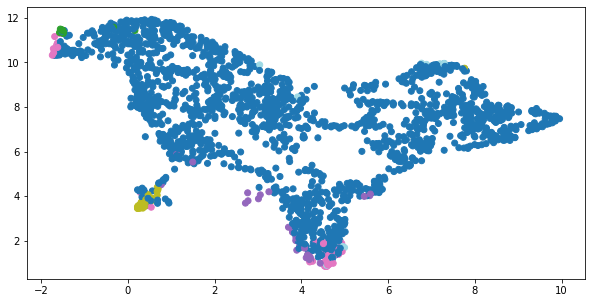

In [11]:
dominant_topics_by_doc = np.argmax(X, axis=1)
plt.figure(figsize=(10, 5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=dominant_topics_by_doc, cmap=plt.cm.get_cmap('tab20'))
plt.show()